# Análise de Indicadores Educacionais: Relações entre Desempenho Escolar, Fatores Socioeconômicos e Geográficos

**Trabalho Prático 2**

**Disciplina**: Introdução a Banco de Dados

**Professor**: Clodoveu Davis

**Integrantes**:

Isabel Silva Mitraud Ruas 2022040230

Isabela Canuto Paiva 2022040320

Nicolas Adam Berger Monteiro 2022039950


# Introdução


No Brasil, há uma grande desigualdade de oportunidades educacionais para crianças, adolescentes e adultos, que fica evidente nas diferenças em infraestrutura escolar, capacitação dos professores e rendimento acadêmico dos estudantes. Desse modo, pretendemos analisar neste trabalho prático alguns bancos de dados de indicadores educacionais a fim de descobrir possíveis relações entre indicadores de desempenho (taxa de aprovação, reprovação, abandono) e fatores geográficos, fatores socioeconômicos, fatores relacionados às escolas e aos professores. Esse tipo de análise multifatorial contribui para a elaboração de políticas públicas voltadas para a melhoria da qualidade da educação brasileira e, consequentemente, o desenvolvimento econômico e social do país.

Quanto às expectativas do projeto, acreditamos que as áreas rurais e as escolas da rede pública terão taxas de reprovação e de abandono mais altas do que as regiões urbanas e as escolas da rede privada. Também acreditamos que as escolas com maior percentual de docentes com ensino superior apresentarão as taxas de aprovação mais altas.

Para termos uma quantidade de dados mais viável, decidimos trabalhar com o recorte temporal de 2010 a 2022, para também conseguirmos avaliar o impacto da pandemia nesses indicadores. Além disso, entre as séries escolares disponíveis, optamos por dar um enfoque maior no Ensino Médio e Ensino Fundamental.



Escolhemos os bancos de dados "escola", "escola_nivel_socioeconomico" e "municipio_taxa_transicao", que têm como região geográfica de referência todos os municípios brasileiros e estão disponíveis no site Base dos Dados (https://basedosdados.org/dataset/63f1218f-c446-4835-b746-f109a338e3a1?table=cd65b1d2-45e8-432b-afe8-c3a706addbe8), com a fonte original sendo os Dados Abertos do INEP (https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/indicadores-educacionais). Nosso acesso ao site com as bases tratadas ocorreu em 14/06/2023, e os dados originais foram publicados em 21/10/2020, sendo atualizados em 27/03/2023 e 22/02/2024.

Quanto às limitações percebidas ao longo da realização do trabalho, a mais evidente foi o fato de os arquivos serem muito grandes, principalmente o de "escola", que continha mais de 3 milhões de linhas. Além disso, todas as tabelas possuem muitos dados faltantes. Fizemos a contagem desses dados nulos para deixar registrado e também retiramos as linhas que estavam com todas as colunas faltantes, para não interferirem nas análises.

Tínhamos como um dos objetivos avaliar as relações a nível estadual, portanto teve que ser feito um reajuste para obtermos a coluna "UF" a partir do ID do município, já que os dois primeiros algarismos dos sete que compõem o código do município se referem ao seu estado correspondente.

Na tabela que continha os dados sobre o nível socioeconômico, os únicos anos disponíveis no site Base dos Dados eram os de 2014 e 2015, o que limitou as nossas análises. Na fonte original, o recorte temporal também não é muito mais abrangente, contendo os anos 2021, 2019, 2015 e 2011-2013.

Por fim, encontramos dificuldades ao utilizar o PostgreSQL. A parte de criação de tabelas e de um database funcionou corretamente, porém, na hora de carregar os dados dentro dessas tabelas, ocorriam erros, mesmo sendo um arquivo CSV e especificando as delimitações das colunas por vírgulas. Por conta disso, decidimos utilizar o SQLite3 do Python, que serve como um SGBD relacional embutido, sem necessidade de criação de um servidor.


# Importação Bibliotecas


In [2]:
import io
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium import Choropleth
import matplotlib.image as mpimg

# Esquema Relacional

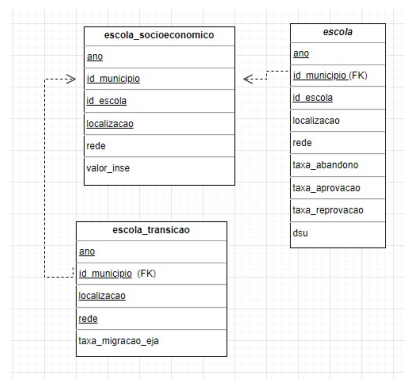

In [5]:
img = mpimg.imread('/content/Esquema-Relacional.png')

# Exibe a imagem
plt.imshow(img)
plt.axis('off')  # Oculta os eixos
plt.show()

# Criação de tabelas

In [ ]:
conn = sqlite3.connect('indices_educacionais.db')
cursor = conn.cursor()

cursor.execute('''
CREATE TABLE IF NOT EXISTS escola_socioeconomico (
    ano INTEGER,
    id_municipio INTEGER,
    id_escola INTEGER,
    area CHARACTER,
    localizacao CHARACTER,
    rede CHARACTER,
    inse_quantidade_alunos INTEGER,
    valor_inse REAL,
    inse_classificacao_2014 CHARACTER,
    inse_classificacao_2015 CHARACTER,
    PRIMARY KEY (id_municipio, id_escola, ano)
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS escola (
    ano INTEGER,
    id_municipio INTEGER,
    id_escola INTEGER,
    localizacao CHARACTER,
    rede CHARACTER,
    atu_ei REAL,
    atu_ef REAL,
    atu_ef_anos_iniciais REAL,
    atu_ef_anos_finais REAL,
    atu_em REAL,
    had_ei REAL,
    had_ef REAL,
    had_ef_anos_iniciais REAL,
    had_ef_anos_finais REAL,
    had_em REAL,
    tdi_ef REAL,
    tdi_ef_anos_iniciais REAL,
    tdi_ef_anos_finais REAL,
    tdi_em REAL,
    taxa_aprovacao_ef REAL,
    taxa_aprovacao_ef_anos_iniciais REAL,
    taxa_aprovacao_ef_anos_finais REAL,
    taxa_aprovacao_em REAL,
    taxa_reprovacao_ef REAL,
    taxa_reprovacao_ef_anos_iniciais REAL,
    taxa_reprovacao_ef_anos_finais REAL,
    taxa_reprovacao_em REAL,
    taxa_abandono_ef REAL,
    taxa_abandono_ef_anos_iniciais REAL,
    taxa_abandono_ef_anos_finais REAL,
    taxa_abandono_em REAL,
    dsu_ei REAL,
    dsu_ef REAL,
    dsu_ef_anos_iniciais REAL,
    dsu_ef_anos_finais REAL,
    dsu_em REAL,
    PRIMARY KEY (id_municipio, id_escola, ano),
    FOREIGN KEY (id_municipio) REFERENCES escola_socioeconomico(id_municipio)
)
'''
)

cursor.execute('''
  CREATE TABLE IF NOT EXISTS escola_transicao(
    ano INTEGER,
    id_municipio INTEGER,
    localizacao CHARACTER,
    rede CHARACTER,
    taxa_migracao_eja_ef REAL,
    taxa_migracao_eja_ef_anos_iniciais REAL,
    taxa_migracao_eja_ef_anos_finais REAL,
    taxa_migracao_eja_em REAL,
    PRIMARY KEY (id_municipio, ano, localizacao, rede),
    FOREIGN KEY (id_municipio) REFERENCES escola_socioeconomico(id_municipio),
    FOREIGN KEY (id_municipio) REFERENCES escola(id_municipio)
)
'''
)


conn.commit()

# Tratamentos e conexões com SQL

--> Adicionar textinho explicando esses p's ?


In [ ]:
p0 = pd.read_csv('/content/escola_part_0.csv')
p1 = pd.read_csv('/content/escola_part_1.csv')
p2 = pd.read_csv('/content/escola_part_2.csv')
p3 = pd.read_csv('/content/escola_part_3.csv')
p4 = pd.read_csv('/content/escola_part_4.csv')
p5 = pd.read_csv('/content/escola_part_5.csv')
p6 = pd.read_csv('/content/escola_part_6.csv')
p7 = pd.read_csv('/content/escola_part_7.csv')
p8 = pd.read_csv('/content/escola_part_8.csv')
p9 = pd.read_csv('/content/escola_part_9.csv')
p10 = pd.read_csv('/content/escola_part_10.csv')
p11 = pd.read_csv('/content/escola_part_11.csv')
p12 = pd.read_csv('/content/escola_part_12.csv')
p13 = pd.read_csv('/content/escola_part_13.csv')
p14 = pd.read_csv('/content/escola_part_14.csv')

In [ ]:
df_alunos = pd.concat([p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14])

In [ ]:
df_econ = pd.read_csv('/content/escola_nivel_socioeconomico.csv')
#df_alunos = pd.read_csv('/content/escola_v2.csv')
df_tx_transicao = pd.read_csv('/content/tx_transicao_eja.csv')


In [ ]:
df_alunos.drop(columns=['Unnamed: 0'], inplace=True)
df_tx_transicao.drop(columns=['Unnamed: 0'], inplace=True)


In [ ]:
df_econ.to_sql('escola_socioeconomico', conn, if_exists='append', index=False)
df_alunos.to_sql('escola', conn, if_exists='append', index=False)
df_tx_transicao.to_sql('escola_transicao', conn, if_exists='append', index=False)

286100

In [ ]:
cursor.execute('ALTER TABLE escola_socioeconomico ADD COLUMN uf CHAR(2);')

# Atualizar os valores da coluna uf
cursor.execute('''
    UPDATE escola_socioeconomico
    SET uf = CASE
        WHEN substr(id_municipio, 1, 2) = '11' THEN 'RO'
        WHEN substr(id_municipio, 1, 2) = '12' THEN 'AC'
        WHEN substr(id_municipio, 1, 2) = '13' THEN 'AM'
        WHEN substr(id_municipio, 1, 2) = '14' THEN 'RR'
        WHEN substr(id_municipio, 1, 2) = '15' THEN 'PA'
        WHEN substr(id_municipio, 1, 2) = '16' THEN 'AP'
        WHEN substr(id_municipio, 1, 2) = '17' THEN 'TO'
        WHEN substr(id_municipio, 1, 2) = '21' THEN 'MA'
        WHEN substr(id_municipio, 1, 2) = '22' THEN 'PI'
        WHEN substr(id_municipio, 1, 2) = '23' THEN 'CE'
        WHEN substr(id_municipio, 1, 2) = '24' THEN 'RN'
        WHEN substr(id_municipio, 1, 2) = '25' THEN 'PB'
        WHEN substr(id_municipio, 1, 2) = '26' THEN 'PE'
        WHEN substr(id_municipio, 1, 2) = '27' THEN 'AL'
        WHEN substr(id_municipio, 1, 2) = '28' THEN 'SE'
        WHEN substr(id_municipio, 1, 2) = '29' THEN 'BA'
        WHEN substr(id_municipio, 1, 2) = '31' THEN 'MG'
        WHEN substr(id_municipio, 1, 2) = '32' THEN 'ES'
        WHEN substr(id_municipio, 1, 2) = '33' THEN 'RJ'
        WHEN substr(id_municipio, 1, 2) = '35' THEN 'SP'
        WHEN substr(id_municipio, 1, 2) = '41' THEN 'PR'
        WHEN substr(id_municipio, 1, 2) = '42' THEN 'SC'
        WHEN substr(id_municipio, 1, 2) = '43' THEN 'RS'
        WHEN substr(id_municipio, 1, 2) = '50' THEN 'MS'
        WHEN substr(id_municipio, 1, 2) = '51' THEN 'MT'
        WHEN substr(id_municipio, 1, 2) = '52' THEN 'GO'
        WHEN substr(id_municipio, 1, 2) = '53' THEN 'DF'
        ELSE NULL
    END;
''')

cursor.execute('ALTER TABLE escola ADD COLUMN uf CHAR(2);')

# Atualizar os valores da coluna uf
cursor.execute('''
    UPDATE escola
    SET uf = CASE
        WHEN substr(id_municipio, 1, 2) = '11' THEN 'RO'
        WHEN substr(id_municipio, 1, 2) = '12' THEN 'AC'
        WHEN substr(id_municipio, 1, 2) = '13' THEN 'AM'
        WHEN substr(id_municipio, 1, 2) = '14' THEN 'RR'
        WHEN substr(id_municipio, 1, 2) = '15' THEN 'PA'
        WHEN substr(id_municipio, 1, 2) = '16' THEN 'AP'
        WHEN substr(id_municipio, 1, 2) = '17' THEN 'TO'
        WHEN substr(id_municipio, 1, 2) = '21' THEN 'MA'
        WHEN substr(id_municipio, 1, 2) = '22' THEN 'PI'
        WHEN substr(id_municipio, 1, 2) = '23' THEN 'CE'
        WHEN substr(id_municipio, 1, 2) = '24' THEN 'RN'
        WHEN substr(id_municipio, 1, 2) = '25' THEN 'PB'
        WHEN substr(id_municipio, 1, 2) = '26' THEN 'PE'
        WHEN substr(id_municipio, 1, 2) = '27' THEN 'AL'
        WHEN substr(id_municipio, 1, 2) = '28' THEN 'SE'
        WHEN substr(id_municipio, 1, 2) = '29' THEN 'BA'
        WHEN substr(id_municipio, 1, 2) = '31' THEN 'MG'
        WHEN substr(id_municipio, 1, 2) = '32' THEN 'ES'
        WHEN substr(id_municipio, 1, 2) = '33' THEN 'RJ'
        WHEN substr(id_municipio, 1, 2) = '35' THEN 'SP'
        WHEN substr(id_municipio, 1, 2) = '41' THEN 'PR'
        WHEN substr(id_municipio, 1, 2) = '42' THEN 'SC'
        WHEN substr(id_municipio, 1, 2) = '43' THEN 'RS'
        WHEN substr(id_municipio, 1, 2) = '50' THEN 'MS'
        WHEN substr(id_municipio, 1, 2) = '51' THEN 'MT'
        WHEN substr(id_municipio, 1, 2) = '52' THEN 'GO'
        WHEN substr(id_municipio, 1, 2) = '53' THEN 'DF'
        ELSE NULL
    END;
''')



cursor.execute('ALTER TABLE escola_transicao ADD COLUMN uf CHAR(2);')

# Atualizar os valores da coluna uf
cursor.execute('''
    UPDATE escola_transicao
    SET uf = CASE
        WHEN substr(id_municipio, 1, 2) = '11' THEN 'RO'
        WHEN substr(id_municipio, 1, 2) = '12' THEN 'AC'
        WHEN substr(id_municipio, 1, 2) = '13' THEN 'AM'
        WHEN substr(id_municipio, 1, 2) = '14' THEN 'RR'
        WHEN substr(id_municipio, 1, 2) = '15' THEN 'PA'
        WHEN substr(id_municipio, 1, 2) = '16' THEN 'AP'
        WHEN substr(id_municipio, 1, 2) = '17' THEN 'TO'
        WHEN substr(id_municipio, 1, 2) = '21' THEN 'MA'
        WHEN substr(id_municipio, 1, 2) = '22' THEN 'PI'
        WHEN substr(id_municipio, 1, 2) = '23' THEN 'CE'
        WHEN substr(id_municipio, 1, 2) = '24' THEN 'RN'
        WHEN substr(id_municipio, 1, 2) = '25' THEN 'PB'
        WHEN substr(id_municipio, 1, 2) = '26' THEN 'PE'
        WHEN substr(id_municipio, 1, 2) = '27' THEN 'AL'
        WHEN substr(id_municipio, 1, 2) = '28' THEN 'SE'
        WHEN substr(id_municipio, 1, 2) = '29' THEN 'BA'
        WHEN substr(id_municipio, 1, 2) = '31' THEN 'MG'
        WHEN substr(id_municipio, 1, 2) = '32' THEN 'ES'
        WHEN substr(id_municipio, 1, 2) = '33' THEN 'RJ'
        WHEN substr(id_municipio, 1, 2) = '35' THEN 'SP'
        WHEN substr(id_municipio, 1, 2) = '41' THEN 'PR'
        WHEN substr(id_municipio, 1, 2) = '42' THEN 'SC'
        WHEN substr(id_municipio, 1, 2) = '43' THEN 'RS'
        WHEN substr(id_municipio, 1, 2) = '50' THEN 'MS'
        WHEN substr(id_municipio, 1, 2) = '51' THEN 'MT'
        WHEN substr(id_municipio, 1, 2) = '52' THEN 'GO'
        WHEN substr(id_municipio, 1, 2) = '53' THEN 'DF'
        ELSE NULL
    END;
''')



# Salvar (commit) as mudanças
conn.commit()

## Valores nulos

In [ ]:
query = '''
SELECT COUNT(*)
FROM escola
WHERE atu_ei IS NULL
AND  atu_ef IS NULL
AND  atu_ef_anos_iniciais IS NULL
AND  atu_ef_anos_finais IS NULL
AND  atu_em IS NULL
AND  had_ei IS NULL
AND  had_ef IS NULL
AND  had_ef_anos_iniciais IS NULL
AND  had_ef_anos_finais IS NULL
AND  had_em IS NULL
AND  tdi_ef IS NULL
AND  tdi_ef_anos_iniciais IS NULL
AND  tdi_ef_anos_finais IS NULL
AND  tdi_em IS NULL
AND  taxa_aprovacao_ef IS NULL
AND  taxa_aprovacao_ef_anos_iniciais IS NULL
AND  taxa_aprovacao_ef_anos_finais IS NULL
AND  taxa_aprovacao_em IS NULL
AND  taxa_reprovacao_ef IS NULL
AND  taxa_reprovacao_ef_anos_iniciais IS NULL
AND  taxa_reprovacao_ef_anos_finais IS NULL
AND  taxa_reprovacao_em IS NULL
AND  taxa_abandono_ef IS NULL
AND  taxa_abandono_ef_anos_iniciais IS NULL
AND  taxa_abandono_ef_anos_finais IS NULL
AND  taxa_abandono_em IS NULL
AND  dsu_ei IS NULL
AND  dsu_ef IS NULL
AND  dsu_ef_anos_iniciais IS NULL
AND  dsu_ef_anos_finais IS NULL
AND  dsu_em IS NULL
OR   ano IS NULL
'''

df_nulos_escola = pd.read_sql(query, conn)
df_nulos_escola


,COUNT(*)
0,78865


Como mencionado anteriormente, notamos a presença de muitos valores faltantes na tabela, um total de 78865 na tabela "escola", e tomamos a decisão de retirar essas observações da base.

In [ ]:
query = '''
SELECT COUNT(*)
FROM escola_socioeconomico
WHERE inse_quantidade_alunos IS NULL
AND  valor_inse IS NULL
OR  ano IS NULL
'''



df_nulos_escola_socioeconomico = pd.read_sql(query, conn)
df_nulos_escola_socioeconomico

,COUNT(*)
0,0


In [ ]:
query = '''
SELECT COUNT(*)
FROM escola_transicao
WHERE taxa_migracao_eja_ef IS NULL
AND  taxa_migracao_eja_ef_anos_iniciais IS NULL
AND  taxa_migracao_eja_ef_anos_finais IS NULL
AND  taxa_migracao_eja_em IS NULL
OR  ano IS NULL
'''

df_nulos_escola_transicao = pd.read_sql(query, conn)
df_nulos_escola_transicao

,COUNT(*)
0,122


## Deletando onde tudo é nulo junto

In [ ]:
delete_query = '''
DELETE FROM escola
WHERE atu_ei IS NULL
AND  atu_ef IS NULL
AND  atu_ef_anos_iniciais IS NULL
AND  atu_ef_anos_finais IS NULL
AND  atu_em IS NULL
AND  had_ei IS NULL
AND  had_ef IS NULL
AND  had_ef_anos_iniciais IS NULL
AND  had_ef_anos_finais IS NULL
AND  had_em IS NULL
AND  tdi_ef IS NULL
AND  tdi_ef_anos_iniciais IS NULL
AND  tdi_ef_anos_finais IS NULL
AND  tdi_em IS NULL
AND  taxa_aprovacao_ef IS NULL
AND  taxa_aprovacao_ef_anos_iniciais IS NULL
AND  taxa_aprovacao_ef_anos_finais IS NULL
AND  taxa_aprovacao_em IS NULL
AND  taxa_reprovacao_ef IS NULL
AND  taxa_reprovacao_ef_anos_iniciais IS NULL
AND  taxa_reprovacao_ef_anos_finais IS NULL
AND  taxa_reprovacao_em IS NULL
AND  taxa_abandono_ef IS NULL
AND  taxa_abandono_ef_anos_iniciais IS NULL
AND  taxa_abandono_ef_anos_finais IS NULL
AND  taxa_abandono_em IS NULL
AND  dsu_ei IS NULL
AND  dsu_ef IS NULL
AND  dsu_ef_anos_iniciais IS NULL
AND  dsu_ef_anos_finais IS NULL
AND  dsu_em IS NULL
OR ano IS NULL
'''


cursor.execute(delete_query)

# Confirmar a exclusão
conn.commit()


In [ ]:
delete_query = '''
DELETE FROM escola_transicao
WHERE taxa_migracao_eja_ef IS NULL
AND  taxa_migracao_eja_ef_anos_iniciais IS NULL
AND  taxa_migracao_eja_ef_anos_finais IS NULL
AND  taxa_migracao_eja_em IS NULL
OR ano IS NULL
'''


cursor.execute(delete_query)

# Confirmar a exclusão
conn.commit()

# Dicionário dos dados

* ano: ano (2010-2022 para a tabela escola e 2014-2015 para a tabela escola_nivel_socioeconomico);
* id_municipio: código de 7 algarismos referentes ao município brasileiro;
* id_escola: código da escola;
* localizacao: urbana ou rural;
* rede: rede da escola (privada, municipal, estadual, federal);
* valor_inse: média do Indicador de Nível Socioeconômico dos alunos da escola;
* uf: código de 2 algarismos referente ao estado brasileiro.

Para as seguintes colunas, o final “_ef” se refere ao Ensino Fundamental e o final “_em” se refere ao Ensino Médio:
* taxa_aprovacao: proporção de alunos que foram aprovados na série em que estavam matriculados;
* taxa_reprovacao: proporção de alunos que foram reprovados na série em que estavam matriculados;
* taxa_abandono: proporção de alunos que deixaram de frequentar a escola durante o ano letivo;
* taxa_migracao_eja: proporção de alunos que estavam matriculados em uma série x e no ano seguinte estavam matriculados na EJA;
* dsu: percentual de docentes com curso superior.


# Análise Exploratória

## Objetivos

Tem-se como objetivo dessa análise relacionar o Índice de Nível Socioeconômico (INSE), taxas de abandono, reprovação, aprovação, professores com ensino superior e taxas de migração para o EJA. Isso verificando tendências ao longo dos anos, ou de aspectos espaciais, ou por variáveis categóricas como localização.  


## Taxa de Abandono

### Consulta média de taxa de abandono EM e valor INSE

In [ ]:
query = '''
SELECT escola.uf, AVG(escola.taxa_abandono_em) AS Taxa_abandono_em, AVG(escola_socioeconomico.valor_inse) AS valor_inse
FROM escola
JOIN escola_socioeconomico
ON escola.id_municipio = escola_socioeconomico.id_municipio
AND escola.id_escola = escola_socioeconomico.id_escola
AND escola.ano = escola_socioeconomico.ano
GROUP BY escola.uf
Order by Taxa_abandono_em DESC
'''

df_abandono_inse_em = pd.read_sql(query, conn)

Text(0, 0.5, 'Valor INSE')

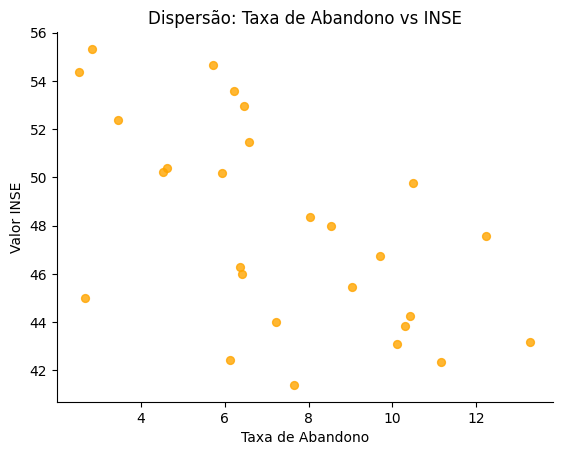

In [ ]:
df_abandono_inse_em.plot(kind='scatter', x='Taxa_abandono_em', y='valor_inse', s=32, alpha=.8, color = 'orange')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Dispersão: Taxa de Abandono vs INSE')
plt.xlabel('Taxa de Abandono')
plt.ylabel('Valor INSE')

Antes de realizar a análise da variável taxa de abandono com a váriavel valor_inse (média do Indicador de Nível Socioeconômico dos alunos da escola), esperávamos identificar uma certa relação de proporcionalidade inversa entre elas, ou seja, quanto maior o valor INSE da escola, menor a sua taxa de abandono.

Isso porque é sabido que um dos fatores mais influentes no abandono escolar é a necessidade de crianças e adolescentes deixarem os estudos de lado para complementar a renda da família que se encontra em situação de necessidade financeira. Segundo dados do Instituto Brasileiro de Geografia e Estatística (IBGE), 4,9% (1.9M) das crianças e adolescentes brasileiras, entre 5 e 17 anos, encontravam-se em situação de trabalho infantil em 2022, sendo que a Constituição proibe qualquer tipo de trabalho para menores de 16 anos (com exceção do trabalho na condição de aprendiz, permitido a partir dos 14 anos). Entre outros fatores que levam ao abandono escolar estão a falta de suporte familiar, a dificuldade de acesso e a gravidez na adolescência, todos também relacionados à vulnerabilidade social.

Além disso, esperávamos que estados com melhores infraestruturas e melhores PIBs (como os da região Sudeste e o Distrito Federal) tivessem as médias de taxa de abandono mais baixas e maior INSE.

Porém, como pode-se notar pelo gráfico de dispersão, não se percebe uma correlação tão aparente entre as duas variáveis.


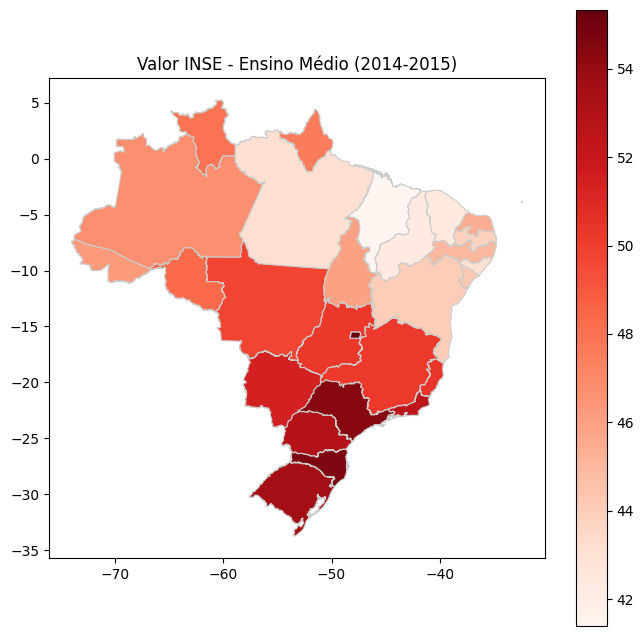

In [ ]:
url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
gdf = gpd.read_file(url)


merged = gdf.set_index('sigla').join(df_abandono_inse_em.set_index('uf'))

# Criar o mapa de calor
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
merged.plot(column='valor_inse', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Valor INSE - Ensino Médio (2014-2015)')
plt.show()

A partir do mapa, fica claro que as regiões mais ao sul do país têm nível socioeconômico dos seus alunos de ensino médio mais elevado, com destaque para São Paulo, Santa Catarina e Distrito Federal, enquanto os estados do Norte e Nordeste têm os piores valores para o INSE, principalmente Maranhão.

### Consulta média de taxa de abandono EF e valor INSE UF

In [ ]:
query = '''
SELECT escola.uf, AVG(escola.taxa_abandono_ef) AS Taxa_abandono_ef, AVG(escola_socioeconomico.valor_inse) AS valor_inse
FROM escola
JOIN escola_socioeconomico
ON escola.id_municipio = escola_socioeconomico.id_municipio
AND escola.id_escola = escola_socioeconomico.id_escola
AND escola.ano = escola_socioeconomico.ano
GROUP BY escola.uf
Order by AVG(escola.taxa_abandono_ef) DESC
'''

df_abandono_inse_ef = pd.read_sql(query, conn)

Text(0, 0.5, 'Valor INSE')

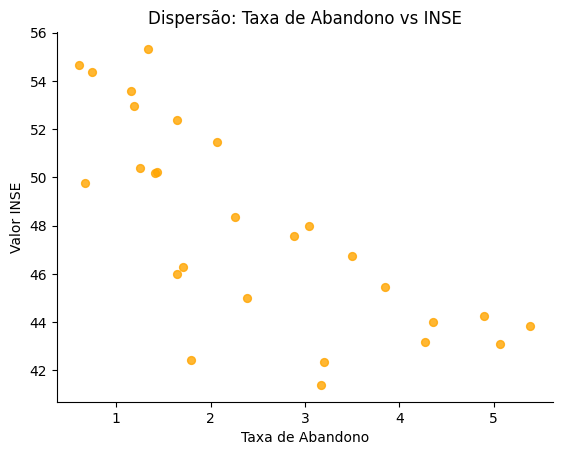

In [ ]:
df_abandono_inse_ef.plot(kind='scatter', x='Taxa_abandono_ef', y='valor_inse', s=32, alpha=.8, color = 'orange')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Dispersão: Taxa de Abandono vs INSE')
plt.xlabel('Taxa de Abandono')
plt.ylabel('Valor INSE')

Fazendo a mesma análise para o Ensino Fundamental, percebe-se que a dispersão já demonstra a tendência esperada de forma mais clara, onde conforme a taxa de abandono aumenta o INSE diminui. Veremos essa correlação mais a frente em nosso projeto, indicando possivelmente uma correlação moderada negativa.

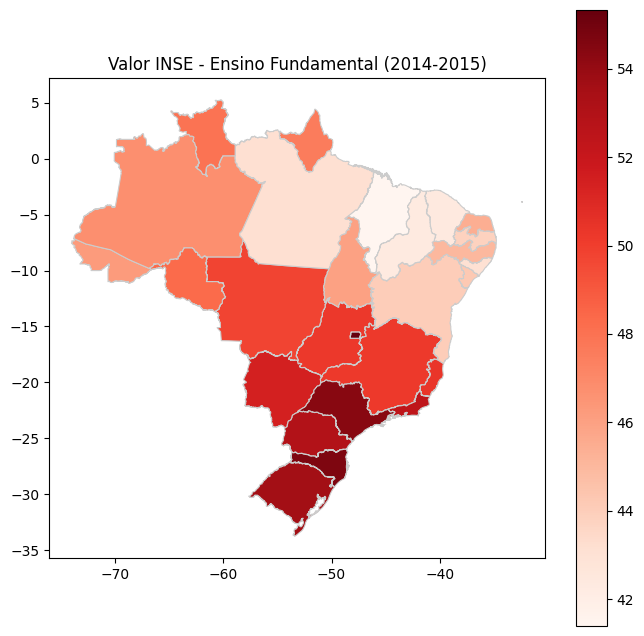

In [ ]:
merged = gdf.set_index('sigla').join(df_abandono_inse_ef.set_index('uf'))

# Criar o mapa de calor
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
merged.plot(column='valor_inse', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Valor INSE - Ensino Fundamental (2014-2015)')
plt.show()

O mapa temático do Valor INSE para o Ensino Fundamental se mostra muito próximo ao mapa referente ao Ensino Médio. Um possível motivo para tal fato seria que escolas de uma mesma região atendem a uma população com perfil socioeconômico parecido.

### Taxa de abandono e localização

In [ ]:
query = '''
SELECT ano, AVG(taxa_abandono_ef) AS Taxa_abandono_ef, localizacao
FROM escola
GROUP BY localizacao, ano
Order by AVG(taxa_abandono_ef) DESC
'''

df_abandono_local_ef = pd.read_sql(query, conn)

<ipython-input-22-effe6e9933aa>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels())


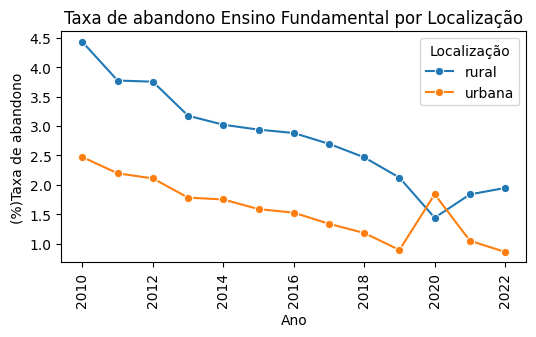

In [ ]:
plt.figure(figsize=(6, 3))
#plt.subplot(1, 3, 3)
ax1 = sns.lineplot(data=df_abandono_local_ef, x='ano', y='Taxa_abandono_ef', hue = 'localizacao',marker='o', color='orange')
ax1.set_xticklabels(ax1.get_xticklabels())
plt.xticks(rotation=90)
legend = ax1.legend(title='Localização')
plt.title('Taxa de abandono Ensino Fundamental por Localização')
plt.xlabel('Ano')
plt.ylabel('(%)Taxa de abandono')
plt.show()

O gráfico acima mostra, ao longo dos anos, como a localização (urbana ou rural) se comporta em relação à taxa de abandono. Pode-se observar que, com o passar dos ano, ambas tiveram um comportamento descrescente, sempre com a urbana tendo uma taxa de abandono menor do que a rural, um resultado já esperado.
No ano de 2020 (começo da pandemia do COVID-19), a localização urbana curiosamente teve uma taxa de abandono ligeiramente acima da rural, e após 2020 a urbana deu início a um comportamento descrescente novamente, e a rural um crescente.

In [ ]:

query = '''
SELECT ano, AVG(taxa_abandono_em) AS Taxa_abandono_em, localizacao
FROM escola
GROUP BY localizacao, ano
Order by AVG(taxa_abandono_em) DESC
'''

df_abandono_local_em = pd.read_sql(query, conn)

<ipython-input-24-388b138b5b50>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels())


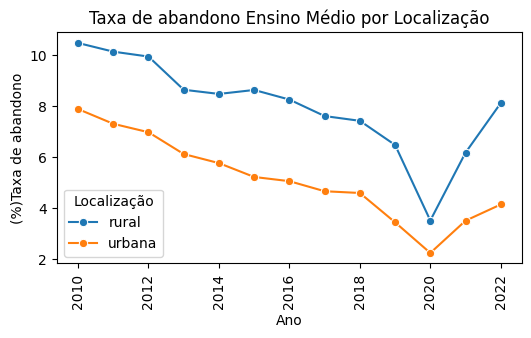

In [ ]:
plt.figure(figsize=(6, 3))
ax1 = sns.lineplot(data=df_abandono_local_em, x='ano', y='Taxa_abandono_em', hue = 'localizacao',marker='o', color=['orange','blue'])
ax1.set_xticklabels(ax1.get_xticklabels())
plt.xticks(rotation=90)
legend = ax1.legend(title='Localização')
plt.title('Taxa de abandono Ensino Médio por Localização')
plt.xlabel('Ano')
plt.ylabel('(%)Taxa de abandono')
plt.show()

No Ensino Médio o comportamente é bem similar, tendo um comportamente descrescente até o ano de início da pandemia, porém, após 2020, ambas localizações começaram um comportamente crescente na taxa de abandono, se mostrando um resultado preocupante. Um possível motivo para o ano de 2020 ter apresentado uma queda tão brusca é subnotificação dos dados por conta de ser um ano atípico de turbulência epidemiológica.

### Taxa de abandono e rede

In [ ]:
query = '''
SELECT AVG(taxa_abandono_em) AS Taxa_abandono_em, rede
FROM escola
GROUP BY rede
Order by AVG(taxa_abandono_em) DESC
'''

df_abandono_rede_em = pd.read_sql(query, conn)

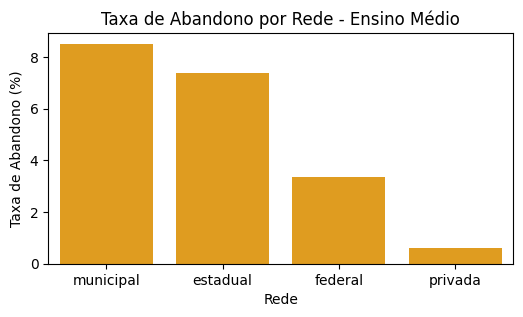

In [ ]:
plt.figure(figsize=(6, 3))
ax = sns.barplot(data=df_abandono_rede_em, x='rede', y='Taxa_abandono_em', color='orange')
plt.title('Taxa de Abandono por Rede - Ensino Médio')
plt.xlabel('Rede')
plt.ylabel('Taxa de Abandono (%)')

plt.show()

In [ ]:

query = '''
SELECT AVG(taxa_abandono_ef) AS Taxa_abandono_ef, rede
FROM escola
GROUP BY rede
Order by AVG(taxa_abandono_ef) DESC
'''

df_abandono_rede_ef = pd.read_sql(query, conn)

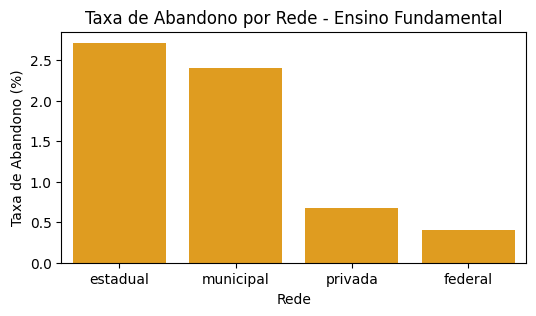

In [ ]:
plt.figure(figsize=(6, 3))
ax = sns.barplot(data=df_abandono_rede_ef, x='rede', y='Taxa_abandono_ef', color='orange')
plt.title('Taxa de Abandono por Rede - Ensino Fundamental')
plt.xlabel('Rede')
plt.ylabel('Taxa de Abandono (%)')

plt.show()

### Taxa abandono ao longo dos anos pra Pernambuco

In [ ]:
query = '''
SELECT ano, AVG(taxa_abandono_ef) AS Taxa_abandono_ef
FROM escola
Where uf = 'PE'
GROUP BY ano
Order by AVG(taxa_abandono_ef) DESC
'''

df_abandono_PE_ef = pd.read_sql(query, conn)

<ipython-input-30-a00faf0fc8dc>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels())


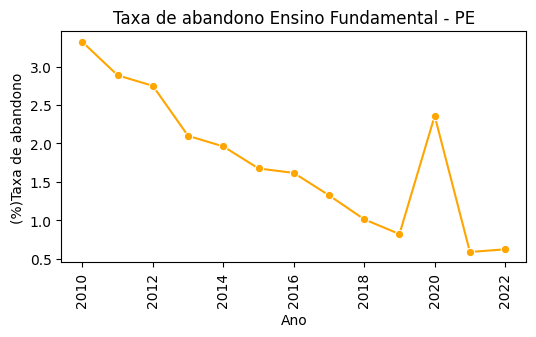

In [ ]:
plt.figure(figsize=(6, 3))
#plt.subplot(1, 3, 3)
ax1 = sns.lineplot(data=df_abandono_PE_ef, x='ano', y='Taxa_abandono_ef', marker='o', color='orange')
ax1.set_xticklabels(ax1.get_xticklabels())
plt.xticks(rotation=90)
plt.title('Taxa de abandono Ensino Fundamental - PE')
plt.xlabel('Ano')
plt.ylabel('(%)Taxa de abandono')
plt.show()

Ao analisar o gráfico de linha da taxa de abandono no Ensino Fundamental em Pernambuco, percebe-se uma queda significativa ao longo do anos, com exceção para o ano de 2020, onde ocorreu um pico. No ano da pandemia, também devemos levar em consideração que muitas escolas não tinham preparo para oferecer o ensino à distância, o que pode ter acarretado num abandono maior por parte de seus alunos neste ano particular.

In [ ]:
query = '''
SELECT ano, AVG(taxa_abandono_em) AS Taxa_abandono_em
FROM escola
Where uf = 'PE'
GROUP BY ano
Order by AVG(taxa_abandono_em) DESC
'''

df_abandono_PE_em = pd.read_sql(query, conn)

<ipython-input-32-eb7eef30ea23>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels())


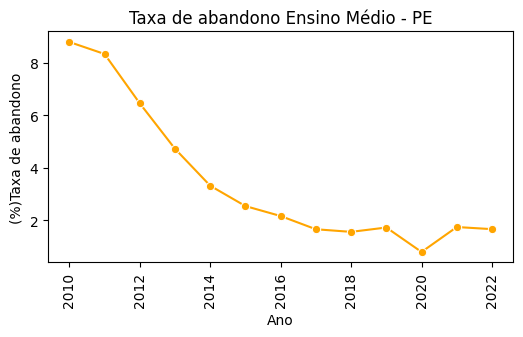

In [ ]:
plt.figure(figsize=(6, 3))
#plt.subplot(1, 3, 3)
ax1 = sns.lineplot(data=df_abandono_PE_em, x='ano', y='Taxa_abandono_em', marker='o', color='orange')
ax1.set_xticklabels(ax1.get_xticklabels())
plt.xticks(rotation=90)
plt.title('Taxa de abandono Ensino Médio - PE')
plt.xlabel('Ano')
plt.ylabel('(%)Taxa de abandono')
plt.show()

As Unidades Federativas com menor taxa de abandono no Ensino Médio foram São Paulo, Pernambuco, Distrito Federal e Rio de Janeiro.
O fato de Pernambuco ter a segunda menor taxa no país foi uma surpresa para nós, já que esperávamos que estivesse próxima das taxas dos outros estados nordestinos.

Pensamos que houvesse algum erro nos dados, porém, pesquisamos mais sobre o assunto, e de fato o estado de Pernambuco teve uma melhora significativa no ensino ao longo dos anos, resultado de uma série de políticas públicas e projetos articulados em quatro eixos: escolas de tempo integral, gestão pedagógica, infraestrutura e inovação.

Segundo o Instituto Unibanco, em 2007 essa taxa para o ensino médio em Pernambuco era de 24%, e em 2017 ela caiu para 1,5%, ultrapassando São Paulo e sendo o estado com menor taxa de abandono escolar. Além disso, o Ideb (Índice de Desenvolvimento da Educação Básica) passou de 2,7 para 4 (numa escala de 0 a 10) nesses mesmos anos, o terceiro melhor no país.

O gráfico acima mostra essa queda, com destaque, também, para o ano atípico da pandemia de COVID-19.

## Taxa de Aprovação

### Aprovação e Localização

In [ ]:
query = '''
SELECT ano ,localizacao,ROUND(AVG(taxa_aprovacao_em),2)as taxa_aprovacao_em
FROM escola
GROUP BY localizacao,ano
ORDER BY AVG(taxa_aprovacao_em) DESC
'''

df_aprovacao_local_em = pd.read_sql(query, conn)

<ipython-input-34-c2b6f28a4506>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels())


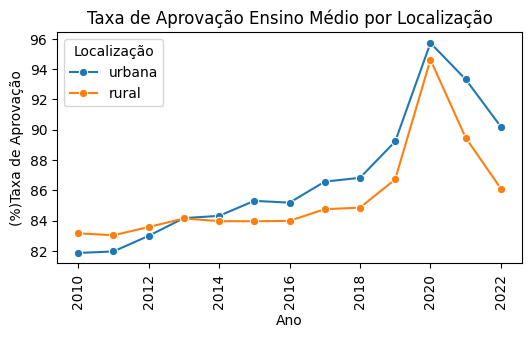

In [ ]:
plt.figure(figsize=(6, 3))
ax1 = sns.lineplot(data=df_aprovacao_local_em, x='ano', y='taxa_aprovacao_em', hue = 'localizacao',marker='o', color=['orange','blue'])
ax1.set_xticklabels(ax1.get_xticklabels())
plt.xticks(rotation=90)
legend = ax1.legend(title='Localização')
plt.title('Taxa de Aprovação Ensino Médio por Localização')
plt.xlabel('Ano')
plt.ylabel('(%)Taxa de Aprovação')
plt.show()

O gráfico de linhas acima mostra as taxas de aprovação no Ensino Médio ao longo dos anos, tanto para as escolas em áreas urbanas quanto rurais. A partir do ano de 2013, a taxa de aprovação pernaneceu com valores mais altos nas escolas urbanas do que nas rurais.

Novamente, percebemos valores atípicos no ano da pandemia. Houve um pico na aprovação no Ensino Médio, para as escolas de ambas localizações, em 2020, possivelmente por flexibilizações nas exigências acadêmicas implementadas durante o ensino remoto. Após esse ano, a taxa apresentou uma queda bem acentuada, com valores mais próximos aos anos anteriores à pandemia.

### Aprovação e % de professores com Ensino Superior

Decidimos trabalhar com o indicador "Porcentagem de professores com ensino superior", pois tínhamos a hipótese de que a melhor qualificação profissional dos docentes pode impactar positivamente no aprendizado dos alunos e refletir em outros indicadores, como a taxa de aprovação. Além disso, esperávamos encontrar uma maior proporção de professores com ensino superior na rede privada ao compará-la com a rede pública, o que não foi o caso.

In [ ]:
query = '''
SELECT rede,ROUND(AVG(taxa_aprovacao_em),2) as taxa_aprovacao_em,ROUND(AVG(dsu_em),2) as percent_prof_ensino_superior
FROM escola
GROUP BY rede
ORDER BY  ROUND(AVG(dsu_em),2) DESC
'''

df_aprovacao_prof_sup_em = pd.read_sql(query, conn)
df_aprovacao_prof_sup_em

,rede,taxa_aprovacao_em,percent_prof_ensino_superior
0,federal,85.38,98.52
1,estadual,83.17,94.06
2,privada,95.35,91.22
3,municipal,84.28,85.80


As escolas federais destacaram-se a maior média de professores com ensino superior, com 98.52%, seguidas pelas estaduais, com 94.06%. Já as privadas e municipais registraram percentuais de 91.22 e 85.8 respectivamente. No entanto, as escolas da rede privada tiveram taxa de aprovação média no Ensino Médio de 95.35%, dez pontos percentuais a mais que as federais, como se percebe no gráfico abaixo.
Embora a rede privada não seja a primeira em termos de porcentagem de professores com ensino superior, ela tem mais recursos financeiros e infraestrutura para oferecer um ensino de qualidade, o que reflete na taxa de aprovação de seus alunos.

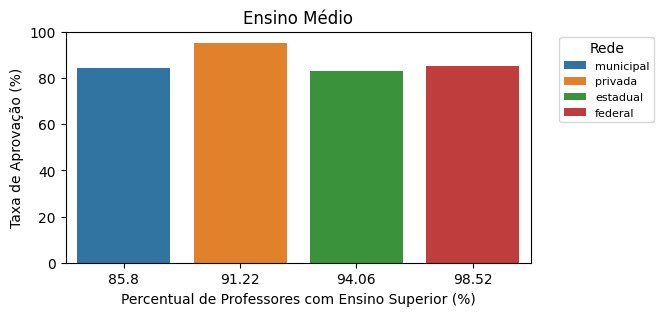

In [ ]:
plt.figure(figsize=(6, 3))
sns.barplot(data=df_aprovacao_prof_sup_em, x='percent_prof_ensino_superior', y='taxa_aprovacao_em', hue = 'rede')

# Adicionar título e rótulos aos eixos
plt.legend(title = 'Rede', bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 8})
plt.title('Ensino Médio')
plt.xlabel('Percentual de Professores com Ensino Superior (%)')
plt.ylabel('Taxa de Aprovação (%)')

# Mostrar o gráfico
plt.show()

## Taxa de reprovação

Similarmente à taxa de aprovação, tínhamos como objetivo avaliar a taxa de reprovação dos alunos com a localização e com a porcentagem de professores com ensino superior, esperando observar os resultados equivalentes: maior taxa de reprovação nas áreas rurais e nas escolas com menos professores com ensino superior.

### Reprovação e % professores com Ensino Superior

In [ ]:
query = '''
SELECT rede,ROUND(AVG(taxa_reprovacao_em),2)as taxa_reprovacao_em,ROUND(AVG(dsu_em),2) as percent_prof_ensino_superior
FROM escola
GROUP BY rede
ORDER BY AVG(taxa_reprovacao_em) DESC
'''

df_reprovacao_prof_sup_em = pd.read_sql(query, conn)
df_reprovacao_prof_sup_em

,rede,taxa_reprovacao_em,percent_prof_ensino_superior
0,federal,11.26,98.52
1,estadual,9.46,94.06
2,municipal,7.20,85.80
3,privada,4.05,91.22


As escolas federais tiveram maior taxa de reprovação, com 11.26%, seguidas pelas estaduais (9.46%), municipais (7.2%) e, por fim, as privadas, com 4.05%.

É interessante ressaltar que, apesar da federal ultrapassar tanto a municipal quanto a estadual na taxa de aprovação, ela teve taxa de reprovação maior que as duas também.

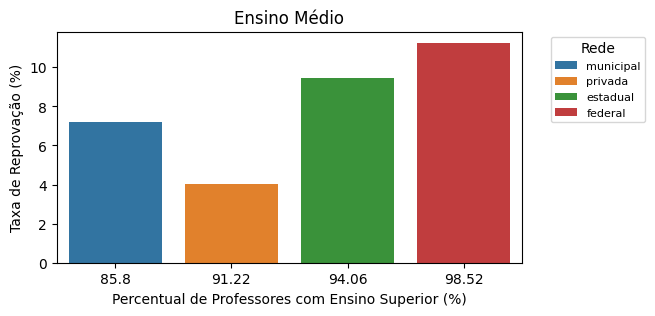

In [ ]:
plt.figure(figsize=(6, 3))
sns.barplot(data=df_reprovacao_prof_sup_em, x='percent_prof_ensino_superior', y='taxa_reprovacao_em', hue = 'rede')

# Adicionar título e rótulos aos eixos
plt.legend(title = 'Rede', bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 8})
plt.title('Ensino Médio')
plt.xlabel('Percentual de Professores com Ensino Superior (%)')
plt.ylabel('Taxa de Reprovação (%)')

# Mostrar o gráfico
plt.show()

Ao comparar este gráfico da taxa de reprovação com o gráfico para a taxa de aprovação, fica mais nítida a diferença entre as redes, já que a escala vai de 0 a 10 e não de 0 a 100.

### Reprovação e Localização

In [ ]:
query = '''
SELECT ano ,localizacao,ROUND(AVG(taxa_reprovacao_em),2)as taxa_reprovacao_em
FROM escola
GROUP BY localizacao,ano
ORDER BY AVG(taxa_reprovacao_em) DESC
'''

df_reprovacao_local_em = pd.read_sql(query, conn)

<ipython-input-40-b448f0649266>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels())


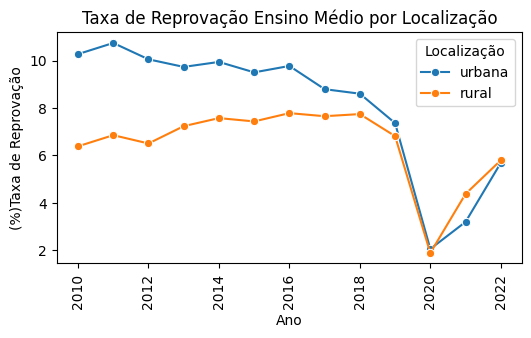

In [ ]:
plt.figure(figsize=(6, 3))
ax1 = sns.lineplot(data=df_reprovacao_local_em, x='ano', y='taxa_reprovacao_em', hue = 'localizacao',marker='o', color=['orange','blue'])
ax1.set_xticklabels(ax1.get_xticklabels())
plt.xticks(rotation=90)
legend = ax1.legend(title='Localização')
plt.title('Taxa de Reprovação Ensino Médio por Localização')
plt.xlabel('Ano')
plt.ylabel('(%)Taxa de Reprovação')
plt.show()

O gráfico de linhas para a a taxa de reprovação no Ensino Médio por localização mostra que as linhas para a urbana e a rural estavam se aproximando uma da outra entre os anos de 2010 e 2019, com essa taxa tendo tendência de diminuição para as escolas em lugares urbanos, e tendo tendência de aumento em lugares rurais.

Mais uma vez, o ano de 2020 mostrou dados bem discrepantes. Para ambas localizações a taxa de reprovação despencou nesse primeiro ano da pandemia, paralelamente com o aumento da taxa de aprovação. Nos anos seguintes, mostrou aumento súbito.

## Professores com Ensino Superior

Passando para uma avaliação somente do indicador professores com ensino superior no espaço, tínhamos como hipótese que as regiões mais ao sul no país tivesse maior porcentagem e regiões ao norte menor porcentagem, tal qual o mapa para o indicador INSE. Porém, essa não foi exatamente a situação observada.

In [ ]:
query = '''
SELECT uf, AVG(dsu_em) as percent_prof_ensino_superior
FROM escola
GROUP BY uf
ORDER BY AVG(dsu_em) DESC
'''

df_prof_sup_em = pd.read_sql(query, conn)

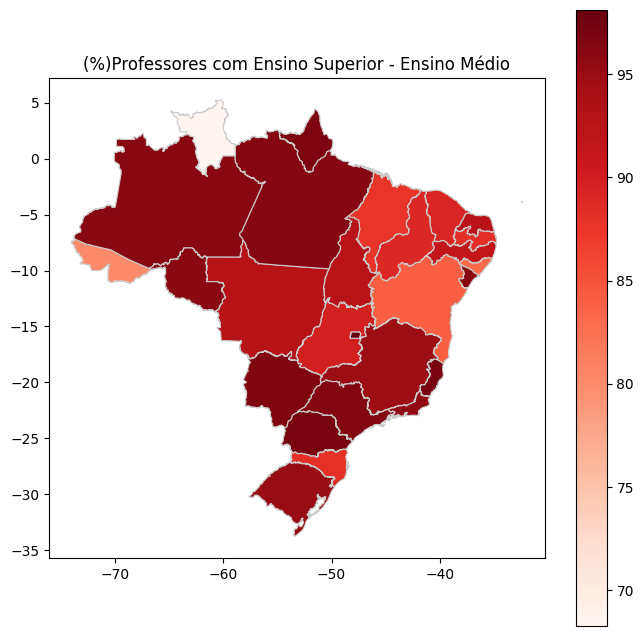

In [ ]:
merged = gdf.set_index('sigla').join(df_prof_sup_em.set_index('uf'))

# Criar o mapa de calor
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
merged.plot(column='percent_prof_ensino_superior', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('(%)Professores com Ensino Superior - Ensino Médio')
plt.show()

Os estados do Sul, Sudente e Centro-Oeste apresentaram, de fato, altas porcentagens de professores com ensino superior. Porém, vários estados do Norte também, como Amazonas, Rondônia, Pará e Amapá, contrastando com os outros dois Acre e Roraima, que se mostraram os estados com as porcentagens mais baixas para o país inteiro.

## Taxa Migração EJA

Optamos por avaliar a taxa de migração para a Educação de Jovens e Adultos (EJA), uma vez que também analisamos as taxas de abandono e reprovação no Ensino Fundamental e Médio ao longo deste trabalho prático.
A modalidade de ensino EJA vem recebendo cada vez mais alunos do ensino regular, sendo 230 mil anos dos anos finais do Ensino Fundamental e 160 mil do ensino médio, segundo o Censo Escolar de 2020. Estes alunos são predominantemente estudantes com histórico de repetência ou abandono.

Vale ressaltar a diferença entre abandono e evasão: abandono é quando o aluno se matricula na escola mas para de atender durante o ano letivo, e evasão é quando ele nem se quer é matriculado na série em que deveria.

Desse modo, esperamos relatar alguma correlação entre a taxa de reprovação e de migração para a EJA.


In [ ]:
query = '''
SELECT uf, AVG(taxa_migracao_eja_em) AS taxa_migracao_eja_em
FROM escola_transicao
GROUP BY uf
ORDER BY AVG(taxa_migracao_eja_em) DESC
'''

df_migracao_eja_em = pd.read_sql(query, conn)
df_migracao_eja_em

,uf,taxa_migracao_eja_em
0,RR,5.031557
1,RO,4.406635
2,PB,3.984047
3,AP,3.734739
4,MT,3.498332
5,DF,3.480000
6,ES,3.250519
7,RJ,2.973361
8,AC,2.799808
9,AL,2.696123


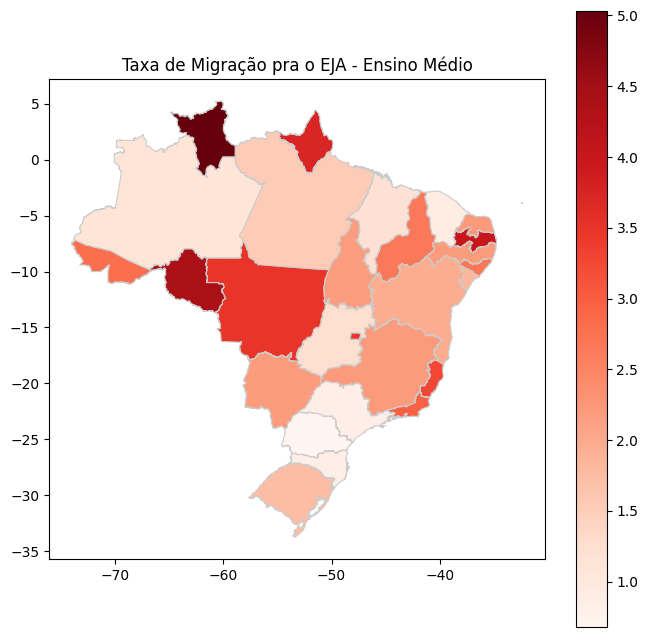

In [ ]:
merged = gdf.set_index('sigla').join(df_migracao_eja_em.set_index('uf'))

# Criar o mapa de calor
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
merged.plot(column='taxa_migracao_eja_em', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Taxa de Migração pra o EJA - Ensino Médio')
plt.show()

O mapa acima revela que os estados de Roraima, Rondônia, Paraíba, Amapá e Mato Grosso tem a maior taxa de migração para a EJA. Novamente o estado de Roraima se destacou.

### Migração e Reprovação

In [ ]:
query = '''
SELECT escola.uf, AVG(escola_transicao.taxa_migracao_eja_em) AS taxa_migracao_eja_em, AVG(escola.taxa_reprovacao_em) AS taxa_reprovacao_em
FROM escola
JOIN escola_transicao ON escola.id_municipio = escola_transicao.id_municipio
AND escola.ano = escola_transicao.ano
AND escola.uf = escola_transicao.uf
GROUP BY escola.uf
ORDER BY AVG(escola.taxa_reprovacao_em) DESC;
'''

df_migracao_eja_reprova_em = pd.read_sql(query, conn)
df_migracao_eja_reprova_em

,uf,taxa_migracao_eja_em,taxa_reprovacao_em
0,MT,3.122872,13.406696
1,RS,2.136306,12.367321
2,MS,2.176396,11.652154
3,BA,1.939871,10.557571
4,DF,3.471182,10.451918
5,RJ,2.647839,10.200263
6,AP,3.766636,9.693900
7,SC,1.073062,9.484492
8,RN,2.321092,9.334086
9,ES,3.421937,9.234313


Text(0, 0.5, 'Taxa de Reprovação')

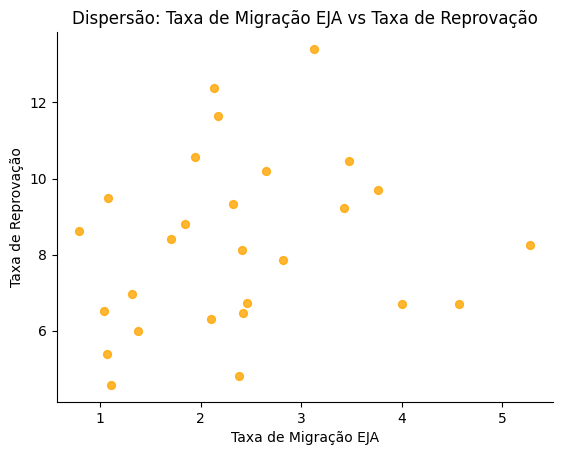

In [ ]:
df_migracao_eja_reprova_em.plot(kind='scatter', x='taxa_migracao_eja_em', y='taxa_reprovacao_em', s=32, alpha=.8, color= 'orange')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Dispersão: Taxa de Migração EJA vs Taxa de Reprovação')
plt.xlabel('Taxa de Migração EJA')
plt.ylabel('Taxa de Reprovação')

Ao analisar o diagrama de dispersão entre as taxa de migração para o EJA e a de reprovação não ficou clara nenhuma tendência entre as duas, o que foi inesperado. Os dados parecem apresentar um padrão aleatório.

## Correlação de todos os dados númericos entre bases

### Ensino Fundamental

In [ ]:
query = '''
SELECT valor_inse, atu_ef, had_ef, tdi_ef, taxa_aprovacao_ef, taxa_reprovacao_ef, taxa_abandono_ef, dsu_ef, taxa_migracao_eja_ef
FROM escola
JOIN escola_socioeconomico ON escola.id_municipio = escola_socioeconomico.id_municipio
AND escola.id_escola = escola_socioeconomico.id_escola
AND escola.ano = escola_socioeconomico.ano
JOIN escola_transicao ON escola.id_municipio = escola_transicao.id_municipio
AND escola.ano = escola_transicao.ano
'''

df_corr_ef = pd.read_sql(query, conn)

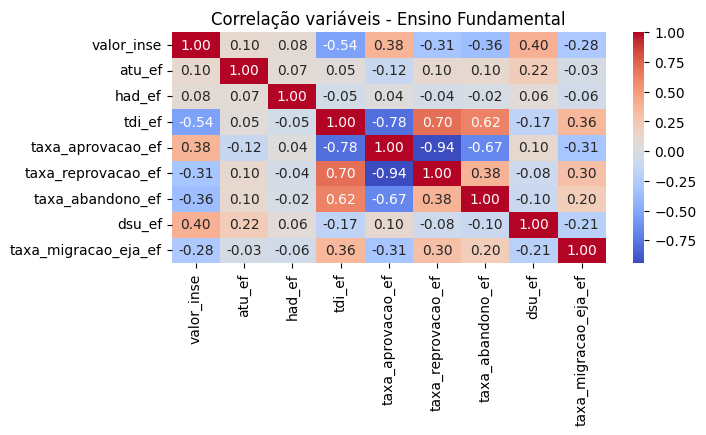

In [ ]:
correlacao_ef = df_corr_ef[['valor_inse','atu_ef','had_ef','tdi_ef','taxa_aprovacao_ef','taxa_reprovacao_ef','taxa_abandono_ef','dsu_ef', 'taxa_migracao_eja_ef']]
correlacao_ef = correlacao_ef.corr()
# Exibir a matriz de correlação
correlacao_ef
plt.figure(figsize=(7, 3))
# Gerar um heatmap da matriz de correlação
sns.heatmap(correlacao_ef, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlação variáveis - Ensino Fundamental')
plt.show()



A matriz de correlação das variáveis para o Ensino Fundamental nos permite fazer algumas conclusões.
A porcentagem de docentes com curso superior (dsu) tem correlação moderada com o valor INSE, assim como a taxa de aprovação.
A taxa de distorção idade-série (tdi) também teve alta correlação com as taxas de aprovação, reprovação e abandono, e moderada com o valor INSE e a taxa de transição para EJA, então esse indicador pode ser uma variável de interesse para estudos futuros.

### Ensino Médio

In [ ]:
query = '''
SELECT valor_inse, atu_em, had_em, tdi_em, taxa_aprovacao_em, taxa_reprovacao_em, taxa_abandono_em, dsu_em, taxa_migracao_eja_em
FROM escola
JOIN escola_socioeconomico ON escola.id_municipio = escola_socioeconomico.id_municipio
AND escola.id_escola = escola_socioeconomico.id_escola
AND escola.ano = escola_socioeconomico.ano
JOIN escola_transicao ON escola.id_municipio = escola_transicao.id_municipio
AND escola.ano = escola_transicao.ano
'''

df_corr_em = pd.read_sql(query, conn)
df_corr_em

,valor_inse,atu_em,had_em,tdi_em,taxa_aprovacao_em,taxa_reprovacao_em,taxa_abandono_em,dsu_em,taxa_migracao_eja_em
0,60.152019,36.5,5.1,8.8,92.3,6.5,1.2,84.6,2.6
1,60.152019,36.5,5.1,8.8,92.3,6.5,1.2,84.6,0.4
2,60.152019,36.5,5.1,8.8,92.3,6.5,1.2,84.6,2.6
3,60.152019,36.5,5.1,8.8,92.3,6.5,1.2,84.6,2.3
4,60.152019,36.5,5.1,8.8,92.3,6.5,1.2,84.6,2.3
...,...,...,...,...,...,...,...,...,...
629779,54.350000,37.2,4.8,15.1,90.5,6.4,3.1,100.0,NaN
629780,54.350000,37.2,4.8,15.1,90.5,6.4,3.1,100.0,0.0
629781,54.350000,37.2,4.8,15.1,90.5,6.4,3.1,100.0,0.3
629782,54.350000,37.2,4.8,15.1,90.5,6.4,3.1,100.0,0.3


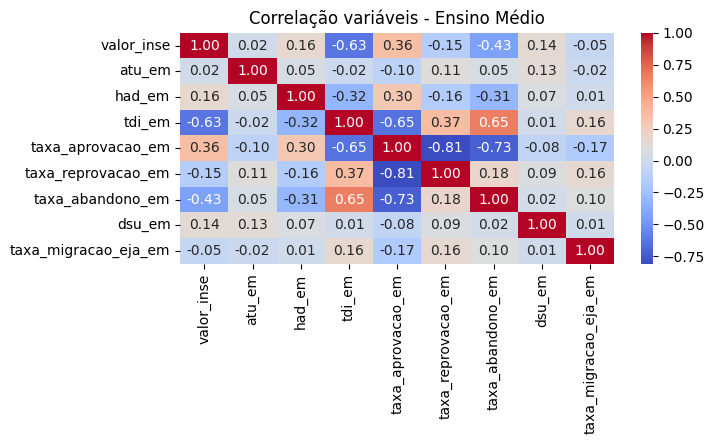

In [ ]:
correlacao_em = df_corr_em[['valor_inse','atu_em','had_em','tdi_em','taxa_aprovacao_em','taxa_reprovacao_em','taxa_abandono_em','dsu_em', 'taxa_migracao_eja_em']]
correlacao_em = correlacao_em.corr()
# Exibir a matriz de correlação
correlacao_em
plt.figure(figsize=(7, 3))
# Gerar um heatmap da matriz de correlação
sns.heatmap(correlacao_em, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlação variáveis - Ensino Médio')
plt.show()

Comparada com a matriz de correlação para o Ensino Fundamental, a matriz do Ensino Médio apresentou correlações mais suaves entre o valor INSE e taxa de migração para a EJA, porcentagem de docentes com curso superior (dsu), mas uma maior correlação com a variável taxa de distorção idade-serie (tdi).

# Github com os dados e código

https://github.com/nicolasabm/tp2IBD

# Referências

Base dos Dados. (n.d.). Tabela de dados do dataset 63f1218f-c446-4835-b746-f109a338e3a1. Disponível em: https://basedosdados.org/dataset/63f1218f-c446-4835-b746-f109a338e3a1?table=cd65b1d2-45e8-432b-afe8-c3a706addbe8


Instituto Nacional de Estudos e Pesquisas Educacionais Anísio Teixeira (INEP). (n.d.). Indicadores educacionais: Dados abertos. Disponível em: https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/indicadores-educacionais


Centro Educa Nexus. (2023, fevereiro). EJA: Jovens e Adultos. Disponível em: https://centroeducanexus.com.br/2023/02/eja-jovens-adultos/#:~:text=S%C3%A3o%2C%20em%20sua%20maioria%2C%20estudantes,n%C3%A3o%20finalizaram%20o%20Ensino%20M%C3%A9dio


Fundação de Apoio ao Desenvolvimento do Ensino, Ciência e Tecnologia do Estado de Mato Grosso do Sul (Fundect). (2023). Abandono escolar volta a subir após mais de dez anos. Disponível em: https://www.fadc.org.br/noticias/abandono-escolar-volta-a-subir-apos-mais-de-dez-anos


Instituto Unibanco. (n.d.). A taxa de abandono escolar: Quais os estados brasileiros com as maiores quedas e aumentos?. Disponível em: https://www.institutounibanco.org.br/aprendizagem-em-foco/47/#:~:text=A%20taxa%20de%20abandono%20escolar,outras%20cinco%20unidades%20da%20federa%C3%A7%C3%A3o


Fundação de Apoio ao Desenvolvimento do Ensino, Ciência e Tecnologia do Estado de Mato Grosso do Sul (Fundect). (n.d.). Conheça os principais problemas que levam ao abandono escolar. Disponível em: https://www.fadc.org.br/noticias/conheca-os-principais-problemas-que-levam-ao-abandono-escolar

